In [1]:
import glob
import DataViz as dv
from random import shuffle
import matplotlib
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import keras
from keras.datasets import cifar10
from keras import models
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
import LoadDataset as LD
import numpy as np
import scipy.misc
from scipy.misc import imresize
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


In [2]:
load_data = LD.LoadData('/netscratch/data/state_farm/imgs/train') # give the directory address.

Dataset directory added
['c6', 'c4', 'c5', 'c8', 'c1', 'c0', 'c7', 'c3', 'c9', 'c2']


In [3]:
# Hyperparameters
batch_size = 500
num_classes = 10
epochs = 30


In [4]:
X = np.load('X.npy')
Y = np.load('Y.npy')
X ,Y = load_data.shuffle_data(X,Y)
print (X.shape)
print(Y.shape)

(22424, 227, 227, 3)
(22424,)


In [5]:
#data split
(x_train, y_train) = (X[0:18000], Y[0:18000])
(x_test, y_test) = (X[18000:], Y[18000:])
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
print(img_height, img_width, channel)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape)

227 227 3
(18000, 227, 227, 3)


In [6]:
#function for running subtsak 1
def AlexNetVarient(input_shp, conv_layer = 5, number_kernal = 96, dence_layer = 2, number_neuron =1000):
    model = Sequential() 
    #initial layer fixed
    model.add(Conv2D(96, (11,11), strides=(4,4),activation='relu', padding='same', input_shape=input_shp))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(BatchNormalization())
    for i in range(conv_layer-1):
        model.add(Conv2D(number_kernal, (3,3), activation='relu', padding='same'))
        
        # Local Response normalization for Original Alexnet
        model.add(BatchNormalization())
    model.add(Flatten())
    for l in range(dence_layer):
        model.add(Dense(number_neuron, activation='relu'))
        model.add(Dropout(0.2))
        
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [63]:
#run subtsk method  and save the result
model_1 = AlexNetVarient((img_height, img_width, channel,),conv_layer=1,number_neuron=50)
model_2 = AlexNetVarient((img_height, img_width, channel,),conv_layer=2,number_neuron=100)
model_3 = AlexNetVarient((img_height, img_width, channel,),conv_layer=3,number_neuron=150)
model_4 = AlexNetVarient((img_height, img_width, channel,),conv_layer=4,number_neuron=200)
model_5 = AlexNetVarient((img_height, img_width, channel,),conv_layer=5,number_neuron=250)
model_6 = AlexNetVarient((img_height, img_width, channel,),conv_layer=6,number_neuron=300)
model_7 = AlexNetVarient((img_height, img_width, channel,),conv_layer=7,number_neuron=450)
model_8 = AlexNetVarient((img_height, img_width, channel,),conv_layer=8,number_neuron=500)
# model_9 = AlexNetVarient((img_height, img_width, channel,),conv_layer=9,number_neuron=1000)

models = [model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8]

In [64]:
model_train_acccuracy = []
model_val_accuracy = []
model_train_time = []
i = 1
for model in models:
    model.summary()
    # determine Loss function and Optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    # Train the Model
    #Preprocessing of images 
    filepath = "best_weight_model_" + str(i) + '.hdf5'
    checkpointer = ModelCheckpoint(filepath=filepath,
                                   monitor='val_acc',
                                   verbose=1,
                                   save_best_only= True)


    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

    start = time.time()
    history = model.fit(x_train, y_train,
                                  batch_size = batch_size,
                                  epochs=epochs,
                                  callbacks=[checkpointer, early_stopping],
                                  verbose=1,
                                  validation_data=(x_test, y_test))
    end = time.time()
    
    score = model.evaluate(x_test, y_test, verbose=0)
    model_train_acccuracy.append(score[0])
    model_val_accuracy.append(score[1])
    total_time = end - start
    model_train_time.append(total_time)
    
    i += 1


    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_212 (Conv2D)          (None, 57, 57, 96)        34944     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 28, 28, 96)        0         
_________________________________________________________________
batch_normalization_212 (Bat (None, 28, 28, 96)        384       
_________________________________________________________________
flatten_32 (Flatten)         (None, 75264)             0         
_________________________________________________________________
dense_140 (Dense)            (None, 50)                3763250   
_________________________________________________________________
dropout_109 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 50)                2550      
__________

Epoch 9/30
18000/18000 [==============================] - 21s 1ms/step - loss: 0.1822 - acc: 0.9328 - val_loss: 0.0454 - val_acc: 0.9860

Epoch 00009: val_acc did not improve from 0.98666
Epoch 10/30
18000/18000 [==============================] - 20s 1ms/step - loss: 0.1483 - acc: 0.9459 - val_loss: 0.0449 - val_acc: 0.9876

Epoch 00010: val_acc improved from 0.98666 to 0.98757, saving model to best_weight_model_3.hdf5
Epoch 11/30
18000/18000 [==============================] - 21s 1ms/step - loss: 0.1302 - acc: 0.9539 - val_loss: 0.0392 - val_acc: 0.9898

Epoch 00011: val_acc improved from 0.98757 to 0.98983, saving model to best_weight_model_3.hdf5
Epoch 12/30
18000/18000 [==============================] - 21s 1ms/step - loss: 0.1212 - acc: 0.9566 - val_loss: 0.0383 - val_acc: 0.9901

Epoch 00012: val_acc improved from 0.98983 to 0.99005, saving model to best_weight_model_3.hdf5
Epoch 13/30
18000/18000 [==============================] - 21s 1ms/step - loss: 0.1215 - acc: 0.9578 - val_

Train on 18000 samples, validate on 4424 samples
Epoch 1/30
18000/18000 [==============================] - 32s 2ms/step - loss: 3.2654 - acc: 0.3061 - val_loss: 2.7255 - val_acc: 0.4473

Epoch 00001: val_acc improved from -inf to 0.44733, saving model to best_weight_model_5.hdf5
Epoch 2/30
18000/18000 [==============================] - 23s 1ms/step - loss: 0.7090 - acc: 0.7567 - val_loss: 0.2282 - val_acc: 0.9458

Epoch 00002: val_acc improved from 0.44733 to 0.94575, saving model to best_weight_model_5.hdf5
Epoch 3/30
18000/18000 [==============================] - 23s 1ms/step - loss: 0.2826 - acc: 0.9020 - val_loss: 0.1690 - val_acc: 0.9555

Epoch 00003: val_acc improved from 0.94575 to 0.95547, saving model to best_weight_model_5.hdf5
Epoch 4/30
18000/18000 [==============================] - 23s 1ms/step - loss: 0.1546 - acc: 0.9485 - val_loss: 0.0755 - val_acc: 0.9819

Epoch 00004: val_acc improved from 0.95547 to 0.98192, saving model to best_weight_model_5.hdf5
Epoch 5/30
18000/1

Train on 18000 samples, validate on 4424 samples
Epoch 1/30


ResourceExhaustedError: OOM when allocating tensor with shape[500,96,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_17/Adam/gradients/zeros_5}} = Fill[T=DT_FLOAT, _class=["loc:@training_17/Adam/gradients/conv2d_239/Relu_grad/ReluGrad"], index_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_17/Adam/gradients/Shape_6, training_17/Adam/gradients/zeros_5/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_17/mul/_14143}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3154_loss_17/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


3


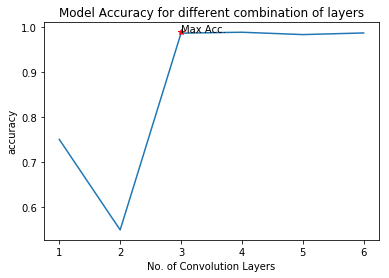

0.9880198915009042
[0.7502260397830018, 0.549502712477396, 0.9859855334538878, 0.9880198915009042, 0.9828209764918626, 0.9864376130198915]


In [65]:
# summarize history for accuracy
x_axis = list(range(1, len(model_val_accuracy)+1))
print(model_val_accuracy.index(max(model_val_accuracy)))
plt.plot(x_axis, model_val_accuracy)
plt.plot(model_val_accuracy.index(max(model_val_accuracy)),max(model_val_accuracy), '*', color='red')
plt.title('Model Accuracy for different combination of layers')
plt.ylabel('accuracy')
plt.xlabel('No. of Convolution Layers')
plt.annotate("Max Acc.", (model_val_accuracy.index(max(model_val_accuracy)),max(model_val_accuracy)))
plt.show()
print(max(model_val_accuracy))
print(model_val_accuracy)
# plt.savefig('Documentation/Subtask_1/validation_plot.png')

In [73]:
best_model_val_acc = []
for i in range(1, len(model_val_accuracy)+1):
    best_model_name = 'best_weight_model_' + str(i) + '.hdf5'
    
    model1 = load_model(best_model_name)
    score = model1.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    best_model_val_acc.append(score[1])

print(best_model_val_acc)

    

Test loss: 0.6426231248900429
Test accuracy: 0.7637884267631103
Test loss: 1.0293619824576765
Test accuracy: 0.6887432188065099
Test loss: 0.035097228341999465
Test accuracy: 0.9914104882459313
Test loss: 0.04134048121012107
Test accuracy: 0.9889240506329114
Test loss: 0.02541854395969912
Test accuracy: 0.9943490054249547
Test loss: 0.03223235296728682
Test accuracy: 0.9927667269439421
[0.7637884267631103, 0.6887432188065099, 0.9914104882459313, 0.9889240506329114, 0.9943490054249547, 0.9927667269439421]


In [85]:

np.save('Documentation/Subtask_1/model_train_accuracy',model_train_acccuracy)
np.save('Documentation/Subtask_1/model_val_accuracy',best_model_val_acc)
np.save('Documentation/Subtask_1/model_train_time',model_train_time)

4
0.9943490054249547
[0.7637884267631103, 0.6887432188065099, 0.9914104882459313, 0.9889240506329114, 0.9943490054249547, 0.9927667269439421]


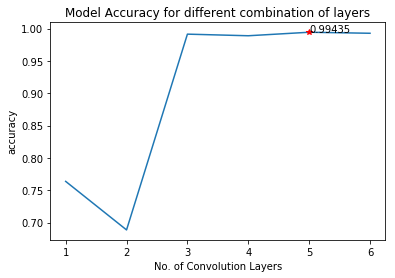

In [84]:
# summarize history for accuracy
x_axis = list(range(1, len(best_model_val_acc)+1))
print(best_model_val_acc.index(max(best_model_val_acc)))
plt.plot(x_axis, best_model_val_acc)
plt.plot(best_model_val_acc.index(max(best_model_val_acc))+1,max(best_model_val_acc), '*', color='red')
plt.title('Model Accuracy for different combination of layers')
plt.ylabel('accuracy')
plt.xlabel('No. of Convolution Layers')
max_val = best_model_val_acc[best_model_val_acc.index(max(best_model_val_acc))]
plt.annotate(round(max_val,5), (best_model_val_acc.index(max(best_model_val_acc))+1,max(best_model_val_acc)))
# plt.show()
print(max(best_model_val_acc))
print(best_model_val_acc)
plt.savefig('Documentation/Subtask_1/validation_plot.png')

563.5274801254272
[563.5274801254272, 210.91232657432556, 330.2939016819, 197.91237449645996, 277.0068917274475, 218.2316927909851]


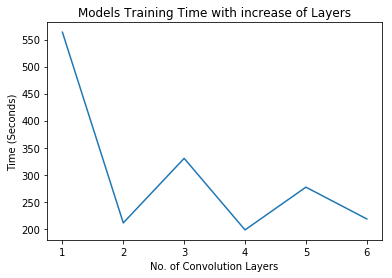

In [86]:
# summarize history for accuracy
x_axis = list(range(1, len(model_train_time)+1))

plt.plot(x_axis, model_train_time)
# plt.plot(best_model_val_acc.index(max(best_model_val_acc))+1,max(best_model_val_acc), '*', color='red')
plt.title('Models Training Time with increase of Layers')
plt.ylabel('Time (Seconds)')
plt.xlabel('No. of Convolution Layers')
# plt.annotate("Max Acc.", (best_model_val_acc.index(max(best_model_val_acc))+1,max(best_model_val_acc)))
# plt.show()
print(max(model_train_time))
print(model_train_time)
plt.savefig('Documentation/Subtask_1/train_time_plot.png')

In [7]:
best_num_conv_layer = 5
best_num_neuron_dense_layer = 250
number_of_kernals = 96

#keep one of variable constant and nd change other and plot the result


#fixed conv layer


In [9]:

model_train_acccuracy_dict = {}
model_val_accuracy_dict = {}
model_train_time_dict = {}

fixed_neurons_models = []

for i in range(1,8):
    fixed_neurons_models.append(AlexNetVarient((img_height, img_width, channel,),conv_layer=i,number_kernal=96,number_neuron=250))

i = 1
for model in fixed_neurons_models:
    model.summary()
    # determine Loss function and Optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    # Train the Model
    #Preprocessing of images 
    file_name = '250_neurons_96_kernels_' + str(i) +"_conv_layers_best_model"
    filepath = 'Documentation/Subtask_1/250_neurons_96_kernels_' + str(i) +"_conv_layers_best_model" + '.hdf5'
    checkpointer = ModelCheckpoint(filepath=filepath,
                                   monitor='val_acc',
                                   verbose=1,
                                   save_best_only= True)


    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

    start = time.time()
    history = model.fit(x_train, y_train,
                                  batch_size = batch_size,
                                  epochs=epochs,
                                  callbacks=[checkpointer, early_stopping],
                                  verbose=1,
                                  validation_data=(x_test, y_test))
    end = time.time()
    
    model1 = load_model(filepath)
    score = model1.evaluate(x_test, y_test, verbose=0)
    
#     score = model.evaluate(x_test, y_test, verbose=0)

    model_train_acccuracy_dict.update({file_name : score[0]})
    model_val_accuracy_dict.update({file_name : score[1]})
    
    total_time = end - start
    model_train_time_dict.update({file_name : total_time})
    
    i += 1
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 57, 57, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 96)        384       
_________________________________________________________________
flatten_1 (Flatten)          (None, 75264)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               18816250  
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
__________

18000/18000 [==============================] - 20s 1ms/step - loss: 0.1088 - acc: 0.9649 - val_loss: 0.0446 - val_acc: 0.9867

Epoch 00007: val_acc did not improve from 0.99051
Epoch 8/30
18000/18000 [==============================] - 20s 1ms/step - loss: 0.1133 - acc: 0.9643 - val_loss: 0.0806 - val_acc: 0.9772

Epoch 00008: val_acc did not improve from 0.99051
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 57, 57, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 96)        384       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 96)        83040     
_________________________________________


Epoch 00007: val_acc did not improve from 0.99186
Epoch 8/30
18000/18000 [==============================] - 22s 1ms/step - loss: 0.0810 - acc: 0.9720 - val_loss: 0.0197 - val_acc: 0.9941

Epoch 00008: val_acc improved from 0.99186 to 0.99412, saving model to Documentation/Subtask_1/250_neurons_96_kernels_4_conv_layers_best_model.hdf5
Epoch 9/30
18000/18000 [==============================] - 22s 1ms/step - loss: 0.0715 - acc: 0.9758 - val_loss: 0.0251 - val_acc: 0.9932

Epoch 00009: val_acc did not improve from 0.99412
Epoch 10/30
18000/18000 [==============================] - 22s 1ms/step - loss: 0.0792 - acc: 0.9730 - val_loss: 0.0219 - val_acc: 0.9934

Epoch 00010: val_acc did not improve from 0.99412
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 57, 57, 96)        34944     
_________________________________________________________________
max_pooling2d_5 (MaxPo

Epoch 2/30
18000/18000 [==============================] - 24s 1ms/step - loss: 0.6871 - acc: 0.7552 - val_loss: 0.3409 - val_acc: 0.8904

Epoch 00002: val_acc improved from 0.52441 to 0.89037, saving model to Documentation/Subtask_1/250_neurons_96_kernels_6_conv_layers_best_model.hdf5
Epoch 3/30
18000/18000 [==============================] - 24s 1ms/step - loss: 0.2875 - acc: 0.8997 - val_loss: 0.1197 - val_acc: 0.9654

Epoch 00003: val_acc improved from 0.89037 to 0.96542, saving model to Documentation/Subtask_1/250_neurons_96_kernels_6_conv_layers_best_model.hdf5
Epoch 4/30
18000/18000 [==============================] - 24s 1ms/step - loss: 0.1656 - acc: 0.9424 - val_loss: 0.0609 - val_acc: 0.9833

Epoch 00004: val_acc improved from 0.96542 to 0.98327, saving model to Documentation/Subtask_1/250_neurons_96_kernels_6_conv_layers_best_model.hdf5
Epoch 5/30
18000/18000 [==============================] - 24s 1ms/step - loss: 0.1019 - acc: 0.9667 - val_loss: 0.0301 - val_acc: 0.9912

Epoc

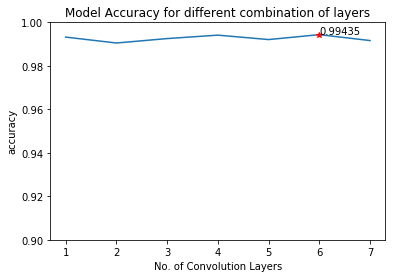

In [34]:
epochs_list = [11, 8, 7, 10, 6, 10, 7]

# summarize history for accuracy
x_axis = list(range(1, len(model_val_accuracy_dict)+1))
y_axis = list(model_val_accuracy_dict.values())

# print(best_model_val_acc.index(max(best_model_val_acc)))
plt.ylim(0.9,1, 0.01)
plt.plot(x_axis, y_axis)
max_val = max(y_axis)
max_ind = y_axis.index(max_val) + 1

plt.plot(max_ind, max_val, '*', color='red')
plt.title('Model Accuracy for different combination of layers')
plt.ylabel('accuracy')
plt.xlabel('No. of Convolution Layers')
# max_val = best_model_val_acc[best_model_val_acc.index(max(best_model_val_acc))]
plt.annotate(round(max_val,5),(max_ind, max_val))
# plt.show()
# print(max(best_model_val_acc))
# print(best_model_val_acc)
plt.savefig('Documentation/Subtask_1/validation_plot_250_neurons_96_kernels_different_conv_layers.png')


In [35]:
np.save('Documentation/Subtask_1/validation_plot_250_neurons_96_kernels_different_conv_layers_model_train_acccuracy_dict',model_train_acccuracy_dict)
np.save('Documentation/Subtask_1/validation_plot_250_neurons_96_kernels_different_conv_layers_model_val_acccuracy_dict',model_val_accuracy_dict)
np.save('Documentation/Subtask_1/validation_plot_250_neurons_96_kernels_different_conv_layers_model_train_time_dict',model_train_time_dict)


In [ ]:
#Fixed unmber of conv layer and neron fixed , vary kernel depth 
best_model_1 = AlexNetVarient((img_height, img_width, channel,),conv_layer=5,number_kernal=96,number_neuron=250)
best_model_1 = AlexNetVarient((img_height, img_width, channel,),conv_layer=5,number_kernal=15,number_neuron=250)
best_model_2 = AlexNetVarient((img_height, img_width, channel,),conv_layer=5,number_kernal=30,number_neuron=250)
best_model_1 = AlexNetVarient((img_height, img_width, channel,),conv_layer=5,number_kernal=60,number_neuron=250)
best_model_1 = AlexNetVarient((img_height, img_width, channel,),conv_layer=5,number_kernal=120,number_neuron=250)
best_model_1 = AlexNetVarient((img_height, img_width, channel,),conv_layer=5,number_kernal=150,number_neuron=250)
best_model_1 = AlexNetVarient((img_height, img_width, channel,),conv_layer=5,number_kernal=200,number_neuron=250)
best_model_1 = AlexNetVarient((img_height, img_width, channel,),conv_layer=5,number_kernal=250,number_neuron=250)


In [ ]:
#Fixed numebr of kernal depth and

In [ ]:
best_model = model_val_accuracy.index(max(model_val_accuracy))
print(best_model)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


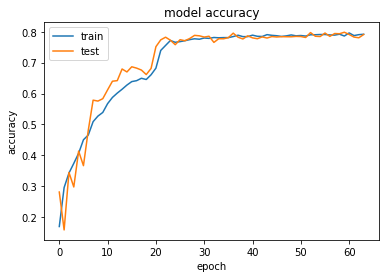

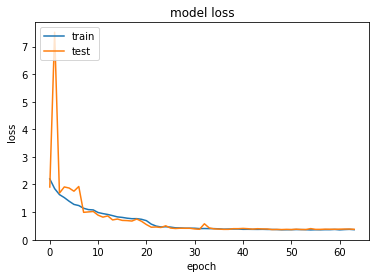

In [15]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()